In [267]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile, expandvars

# data
zenith = 'random' # 'z20' # 
table = 'cleaner_5sgm.pickle'
path = f'{expandvars("$HOME")}/E4/irf_{zenith}/crab/'
dataset = join(path, table)

print(dataset)

# model
if zenith == 'random':
    cnn_name = 'cleaner_zALL'
else:
    cnn_name = f'cleaner_{zenith}'

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infofile = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infofile = join(path, table.replace('.npy', '.dat'))

print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

print(ds['DS1'][0].shape)

/home/dipiano/E4/irf_random/crab/cleaner_5sgm.pickle
Classes: dict_keys(['DS1', 'DS2', 'normalisation'])

NOISY dataset size: 10000
CLEAN dataset size: 10000
(200, 200)


In [268]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (8000, 200, 200, 1)
Train noisy: (8000, 200, 200, 1)

Test clean: (2000, 200, 200, 1)
Test labenoicyls: (2000, 200, 200, 1)


In [269]:
infodata = pd.read_csv(infofile, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
12000,crab_00001,1,0,100,100,244.586146,44.399571,246.427705,44.675062,1.341217,North_z20_N_0.5h_LST,2.5,7.359504
12001,crab_00002,2,0,100,100,236.928863,47.580359,239.178954,48.055799,1.583875,North_z40_N_0.5h_LST,2.5,7.260205
12002,crab_00003,3,0,100,100,177.604276,61.172610,179.962656,60.470637,1.347013,North_z20_N_0.5h_LST,2.5,7.382857
12003,crab_00004,4,0,100,100,242.226627,51.370683,240.935740,51.904333,0.962607,North_z20_S_0.5h_LST,2.5,7.401701
12004,crab_00005,5,0,100,100,64.798566,57.811073,62.515089,57.420957,1.283648,North_z40_N_0.5h_LST,2.5,7.275704


# Seed

In [303]:
idx = np.random.choice(range(len(test_noisy)))
idx = 9664 - 8000
# find seed to get the original heatmap
seed = len(train_noisy) + idx + 1

print(idx), print(seed), len(train_noisy)

1664
9665


(None, None, 8000)

In [304]:
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
9664,crab_09665,9665,0,100,100,99.448219,59.34368,102.829991,59.911583,1.801486,North_z60_0.5h_LST,2.5,6.787184


In [305]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

In [306]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (10, 10)
histsize = (8, 8)
fs = 16

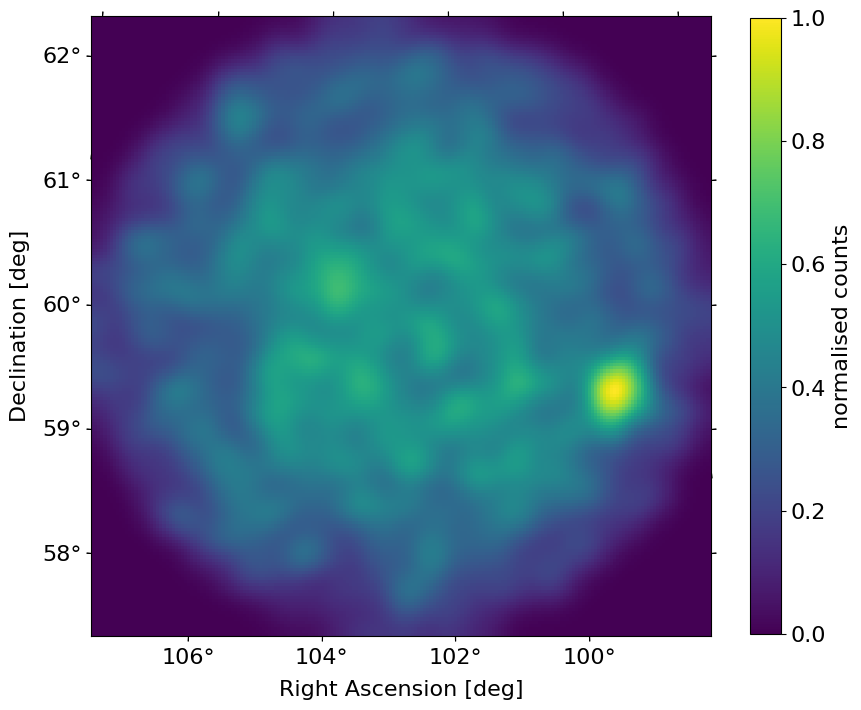

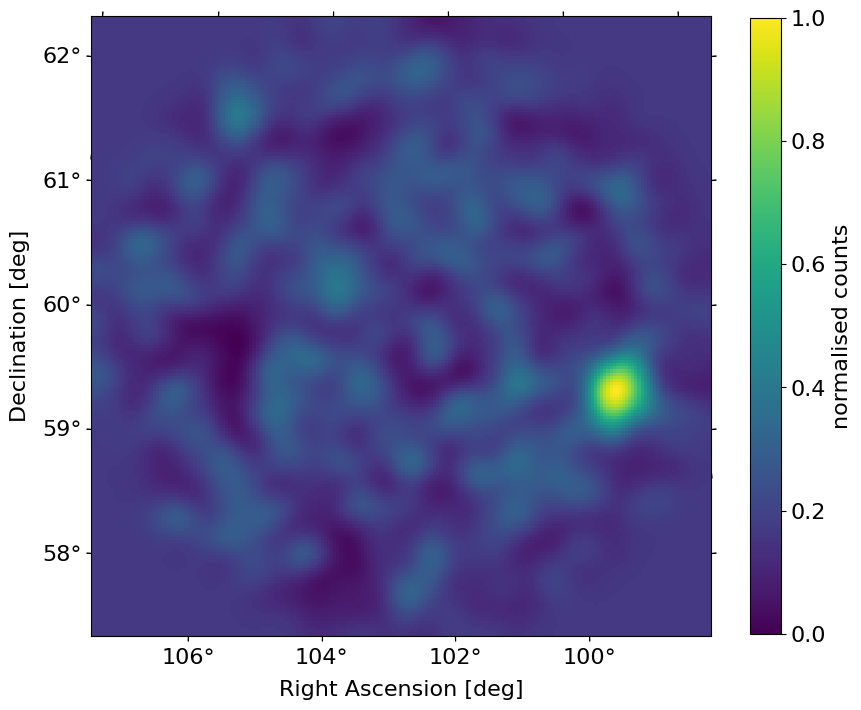

In [307]:
# NOISY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
    
img = ax.imshow(test_noisy[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'noisy map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_sim_noisy.png')
plt.show()

# CLEAN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(test_clean[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_sim_STD.png')
plt.show()

## Load model and weights

In [308]:
import tensorflow as tf

model = tf.keras.models.load_model(f'../models/crta_models/{cnn_name}.keras')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 12)      60        
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 12)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 12)      588       
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 12)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 12)        588   

# Predictions

In [309]:
predictions = model.predict(test_noisy)

63/63 [==============================] - 1s 12ms/step


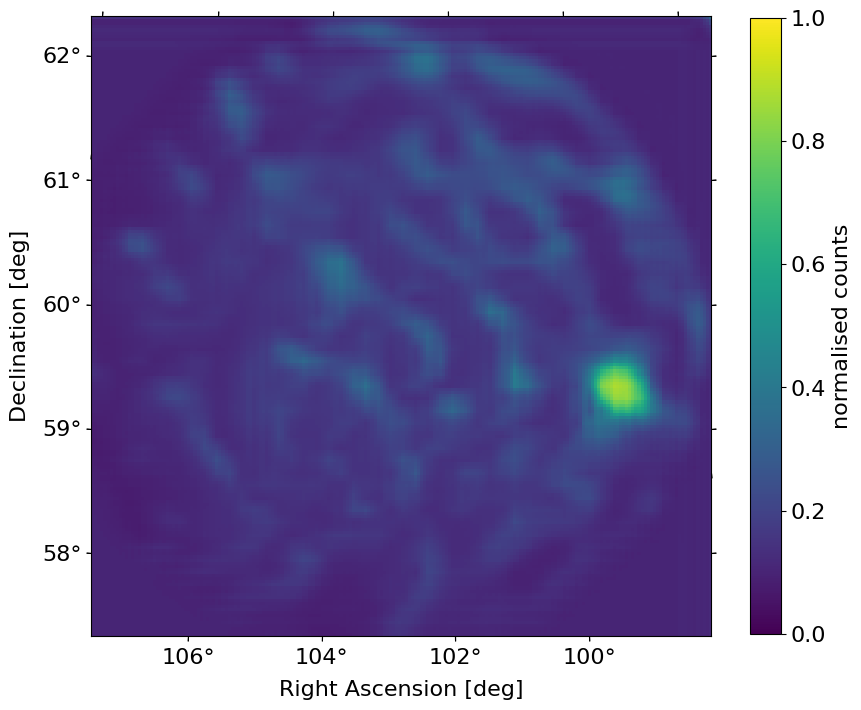

In [310]:
# CLEAN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'denoised map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_cnn_clean_cnn.png')
plt.show()

# Revert normalisation

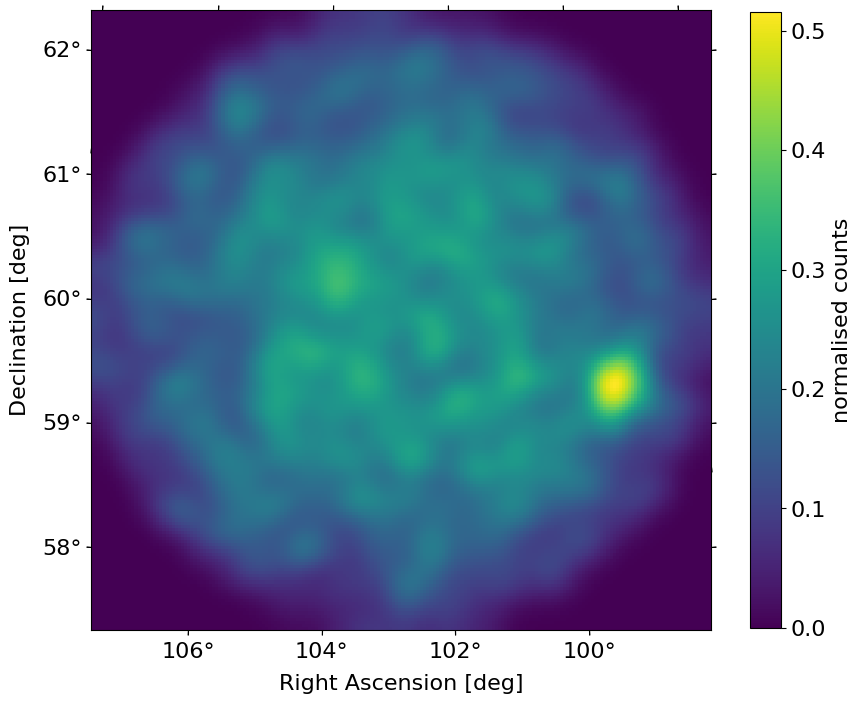

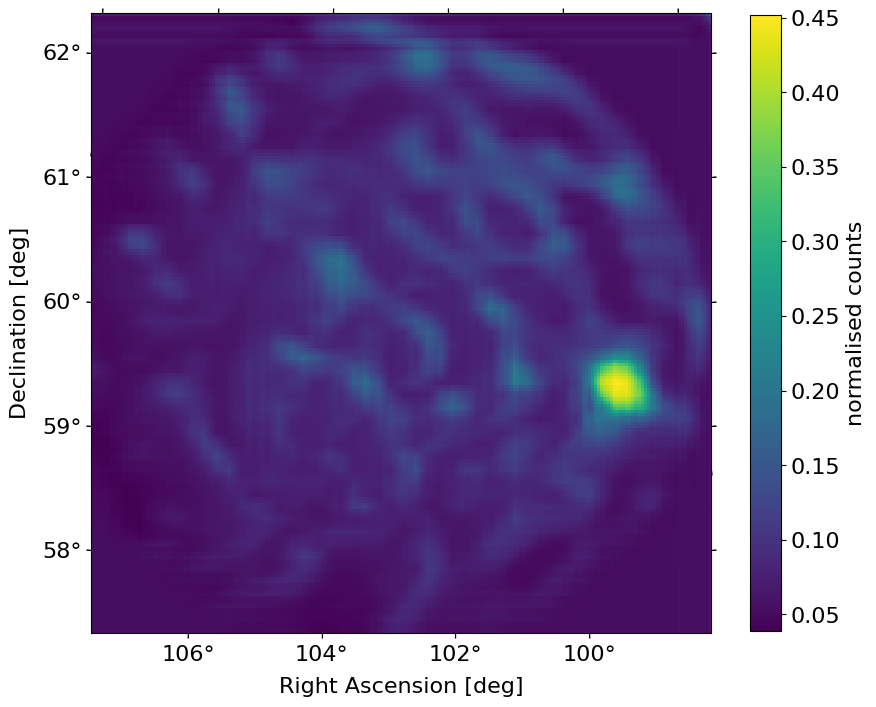

In [311]:
import numpy as np
from astropy.table import Table
from astroai.tools.utils import revert_normalise_heatmap
from astroai.tools.utils import extract_heatmap_from_table, normalise_heatmap

smooth = 5
binning = 200
original = f'{path}/dl3_{zenith}_irf/crab_{seed:05d}.fits'
original_heatmap = Table.read(original, hdu=1).to_pandas()
original_heatmap = extract_heatmap_from_table(original_heatmap, trange=[0, 100], smoothing=smooth, nbins=binning)
revert_noisy_heatmap = revert_normalise_heatmap(test_noisy[idx], original_heatmap)
revert_cnn_heatmap = revert_normalise_heatmap(predictions[idx], original_heatmap)

# DL3
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(revert_noisy_heatmap)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'simulated map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_dl3_noisy.png')
plt.show()

# REVERTED
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(revert_cnn_heatmap)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'denoised map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_cnn_reverted.png')
plt.show()

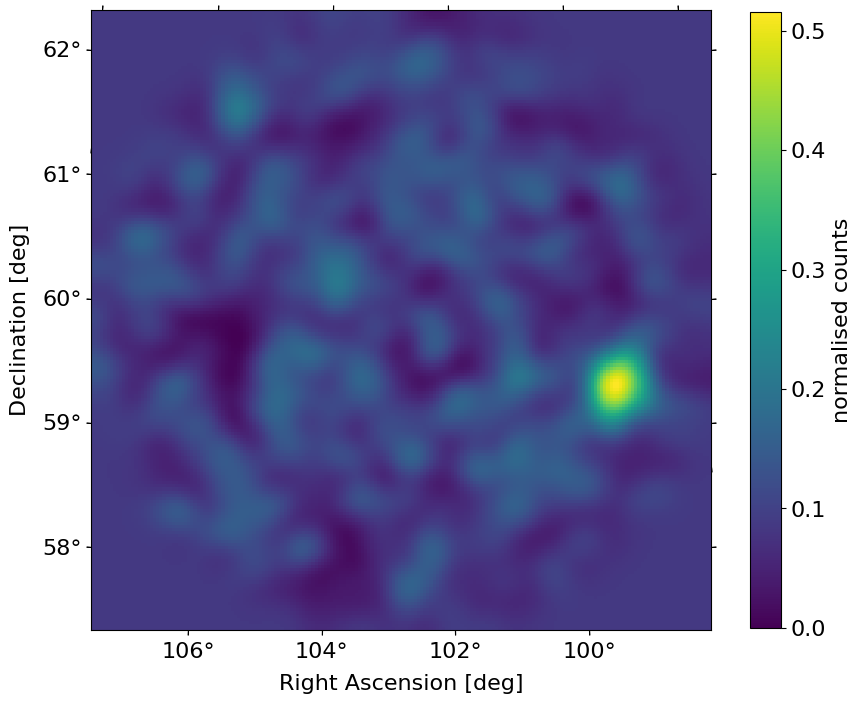

In [312]:
revert_ctools_heatmap = revert_normalise_heatmap(test_clean[idx], original_heatmap)

# REVERTED
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(revert_ctools_heatmap)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_sim_reverted.png')
plt.show()

In [313]:
np.max(original_heatmap), np.max(revert_ctools_heatmap), np.max(revert_cnn_heatmap)

(0.5158739758734068, 0.5158739758734068, 0.45185637)

# Plot loss

In [314]:
loss = model.evaluate(test_noisy, test_clean, verbose=2)

63/63 - 1s - loss: 0.3985 - 1s/epoch - 16ms/step


In [315]:
import matplotlib.pyplot as plt

history = np.load(f'../models/crta_models/{cnn_name}_history.npy', allow_pickle='TRUE').item()
history.keys()

dict_keys(['loss', 'val_loss'])

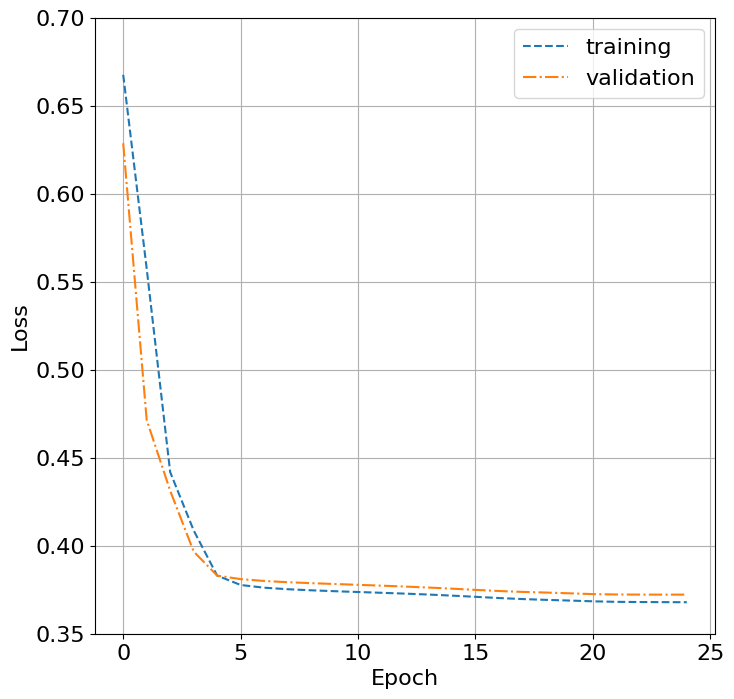

In [316]:
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['loss'][:25], ls='--', label='training')
ax.plot(history['val_loss'][:25], ls='-.', label = 'validation')
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Loss', fontsize=fs)
#ax.set_title('loss function', fontsize=fs*1.5)
ax.set_ylim([0.35,0.7])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/cleaner_loss_FINAL.png')

# Create SRC and PNT coordinates

In [317]:
from astroai.tools.utils import set_wcs
from astropy.coordinates import SkyCoord

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
point_ref, pixelsize

(100.0125, 0.025)

In [318]:
source_x, source_y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                               unit='deg', frame='icrs'))
point_x, point_y = w.world_to_pixel(SkyCoord(row['point_ra'].values[0], row['point_dec'].values[0], 
                                             unit='deg', frame='icrs'))

source_x, source_y, point_x, point_y

(array(167.97114828), array(78.0696718), array(99.025), array(99.025))

In [319]:
source_pix = {'ra': source_x, 'dec': source_y}
point_pix = {'ra': point_x, 'dec': point_y}
source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}

source_pix, point_pix, source_deg, point_deg

({'ra': array(167.97114828), 'dec': array(78.0696718)},
 {'ra': array(99.025), 'dec': array(99.025)},
 {'ra': 99.44821883293888, 'dec': 59.343679857316914},
 {'ra': 102.82999132498476, 'dec': 59.911582749103474})

# Residuals

In [320]:
# clean the all DS NOISY
#ds['DS3'] = model.predict(np.concatenate((train_noisy, test_noisy)))

residuals = {'STD': [], 'CNN': []}

for noisy, clean, pred in zip(test_noisy, test_clean, predictions):
    residuals['STD'].append(noisy - clean)
    residuals['CNN'].append(noisy - pred)
    
len(residuals['STD']), len(residuals['CNN'])

(2000, 2000)

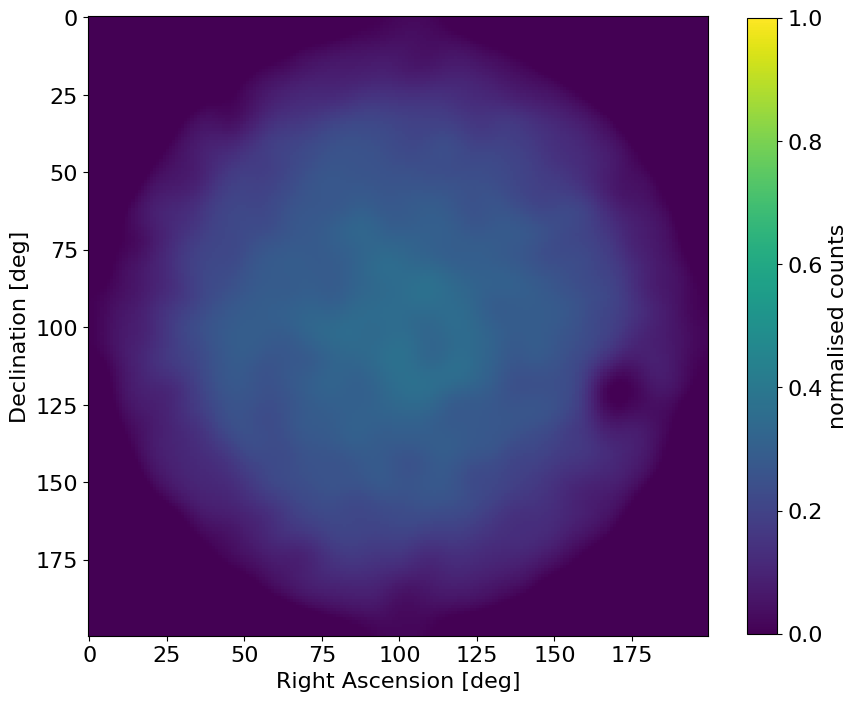

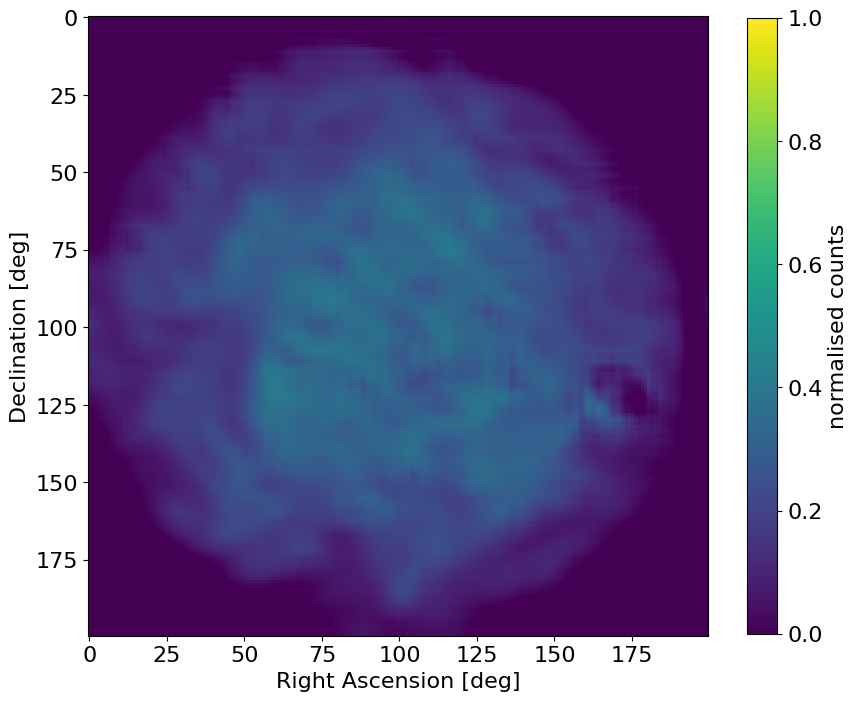

In [321]:
# RESIDUALS STD
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(np.flipud(residuals['STD'][idx]), vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'simulated {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_residuals_sim.png')
plt.show()

# RESIDUALS CNN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(np.flipud(residuals['CNN'][idx]), vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'denoised {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_residuals_cnn.png')
plt.show()

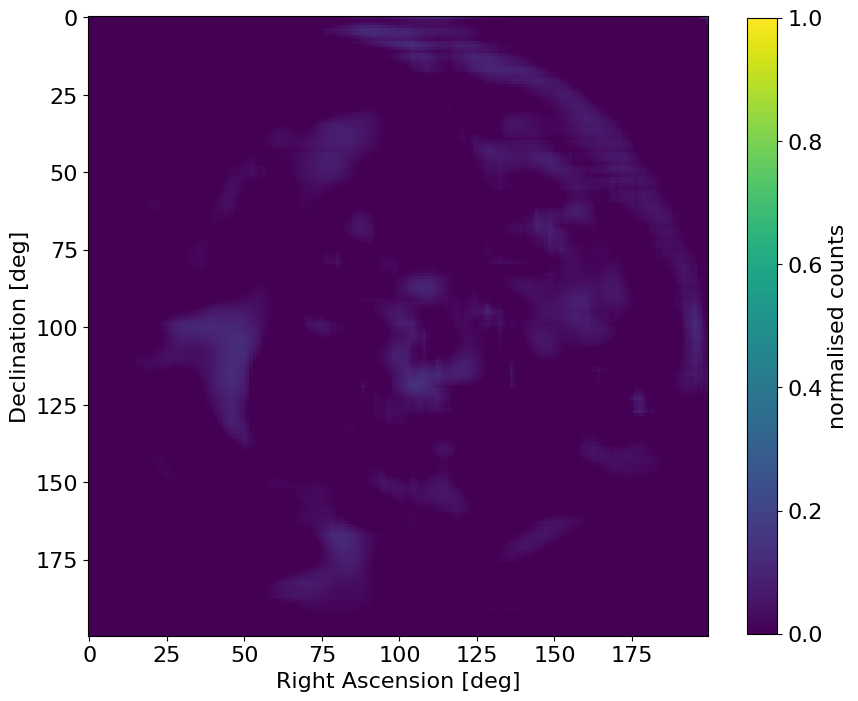

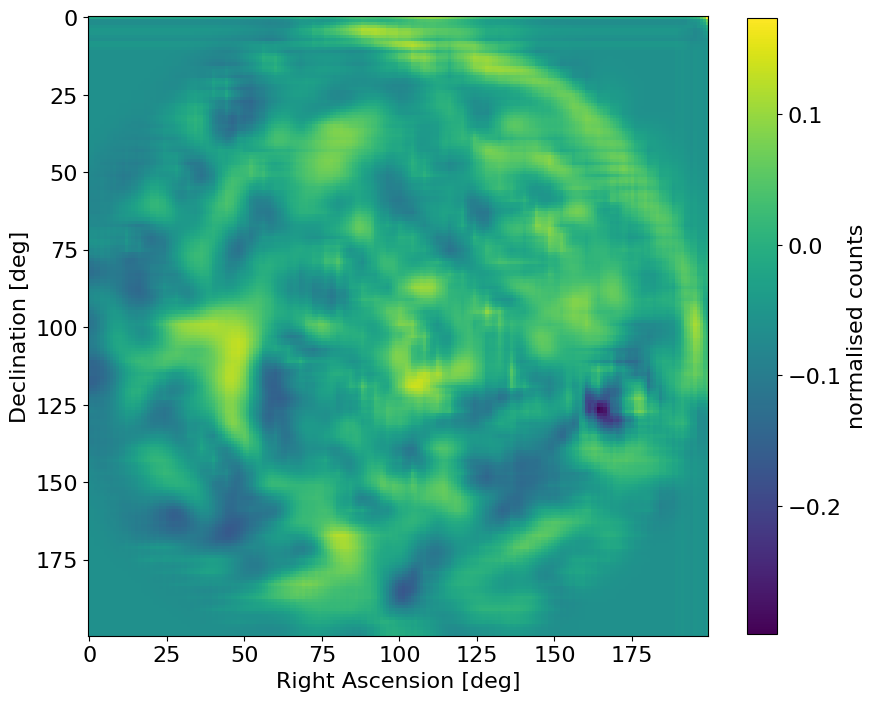

In [322]:
diff = residuals['STD'][idx] - residuals['CNN'][idx]

# RESIDUALS STD
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(np.flipud(diff), vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'simulated {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_residuals_diff.png')
plt.show()

# RESIDUALS CNN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(np.flipud(diff))
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'denoised map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_residuals_vdiff.png')
plt.show()

# Histograms on validation set

In [323]:
sum_residual = {'STD': [], 'CNN': []}
for std, cnn in zip(residuals['STD'], residuals['CNN']):
    sum_residual['STD'].append(np.sum(std))
    sum_residual['CNN'].append(np.sum(cnn))

sum_cleaned = {'STD': [], 'CNN': []}
for std, cnn in zip(test_clean, predictions):
    sum_cleaned['STD'].append(np.sum(std))
    sum_cleaned['CNN'].append(np.sum(cnn))
    
sum_original_and_diff = {'NOISY': [], 'DIFF': []}
for orig, std, cnn in zip(test_noisy, residuals['STD'], residuals['CNN']):
    sum_original_and_diff['NOISY'].append(np.sum(orig))
    sum_original_and_diff['DIFF'].append(np.sum(std - cnn))

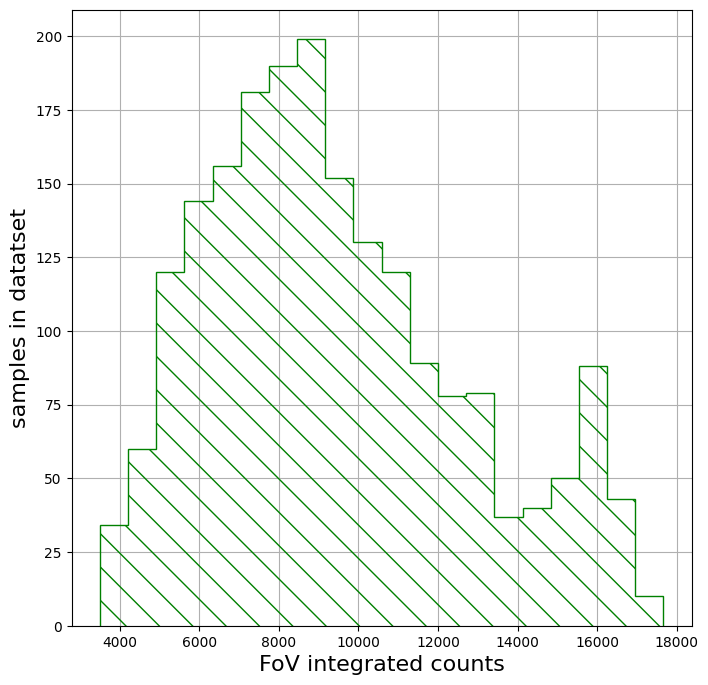

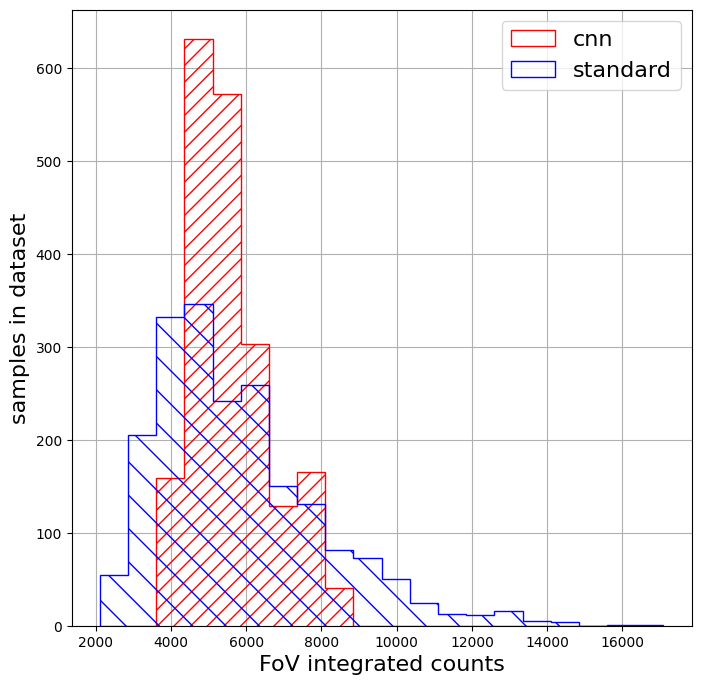

In [324]:
import matplotlib.patches as mpatches

colors = ['blue', 'red']
hatches = ['\\', '//']
legends = [mpatches.Patch(facecolor='none', edgecolor=colors[0], hatch=hatches[0]), 
           mpatches.Patch(facecolor='none', edgecolor=colors[1], hatch=hatches[1])]

# original hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_original_and_diff['NOISY']
#ax.set_title('simulations (noisy)', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color='green')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in datatset', fontsize=fs)
ax.set_xlabel('FoV integrated counts', fontsize=fs)
ax.grid() 

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_noisy_counts.png')
plt.show()

# cumulative counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_cleaned['STD'], sum_cleaned['CNN'])
#ax.set_title('simulations vs predictions (clean)', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors, label=['standard', 'cnn'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('FoV integrated counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_clean_counts.png')
plt.show()

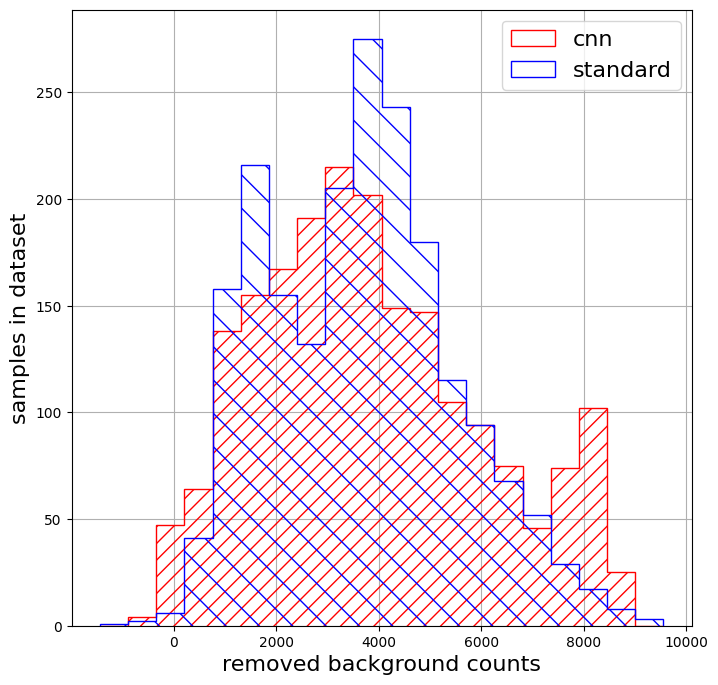

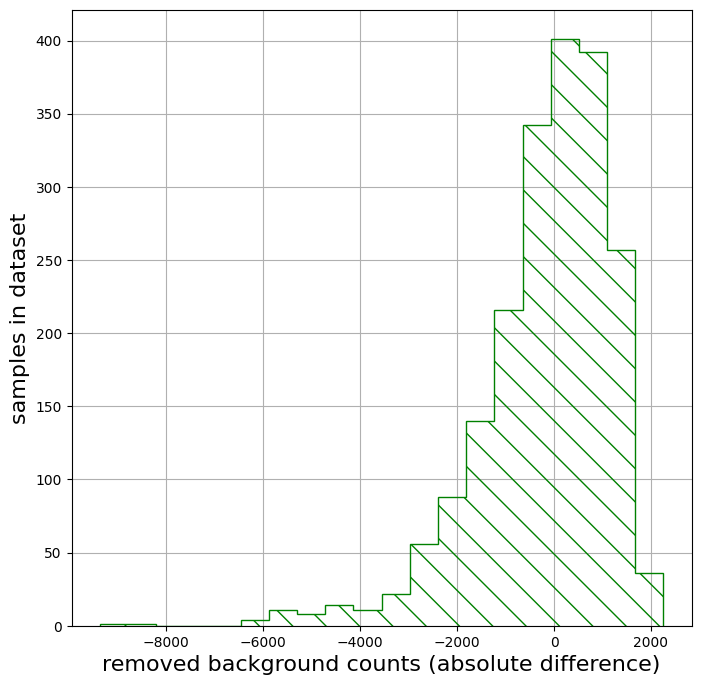

In [325]:
colors = ['blue', 'red']

# residual hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_residual['STD'], sum_residual['CNN'])
#ax.set_title('residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors, label=['standard', 'cnn'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('removed background counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_residuals_counts.png')
plt.show()

# residual diff hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_original_and_diff['DIFF']
#ax.set_title('residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('removed background counts (absolute difference)', fontsize=fs)
ax.grid()

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_residuals_counts_diff.png')
plt.show()

# extract on source counts

/tmp/ipykernel_1179427/4047884411.py:17: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.8)


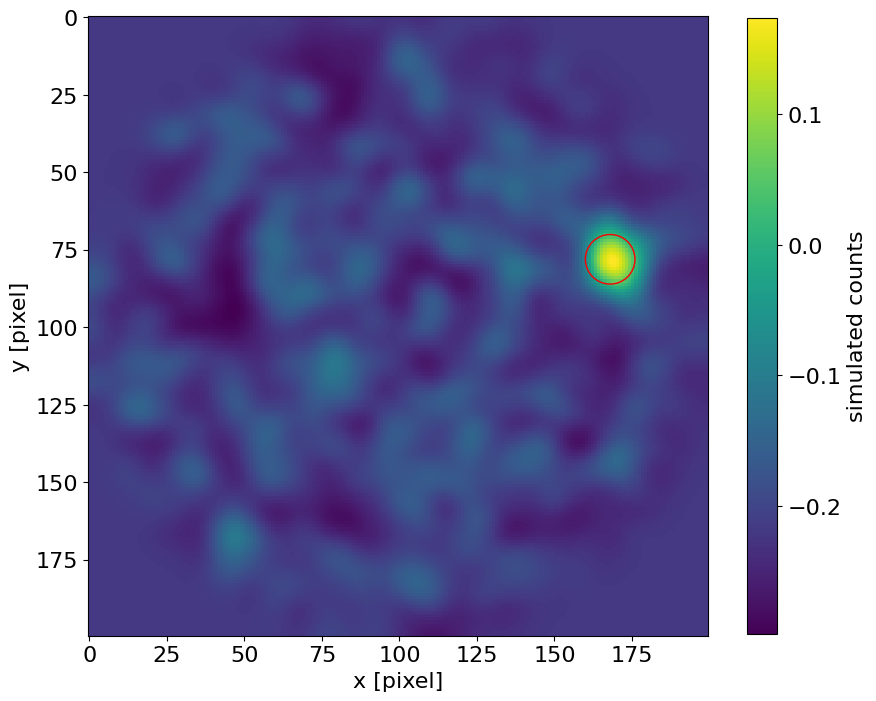

/tmp/ipykernel_1179427/4047884411.py:35: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.8)


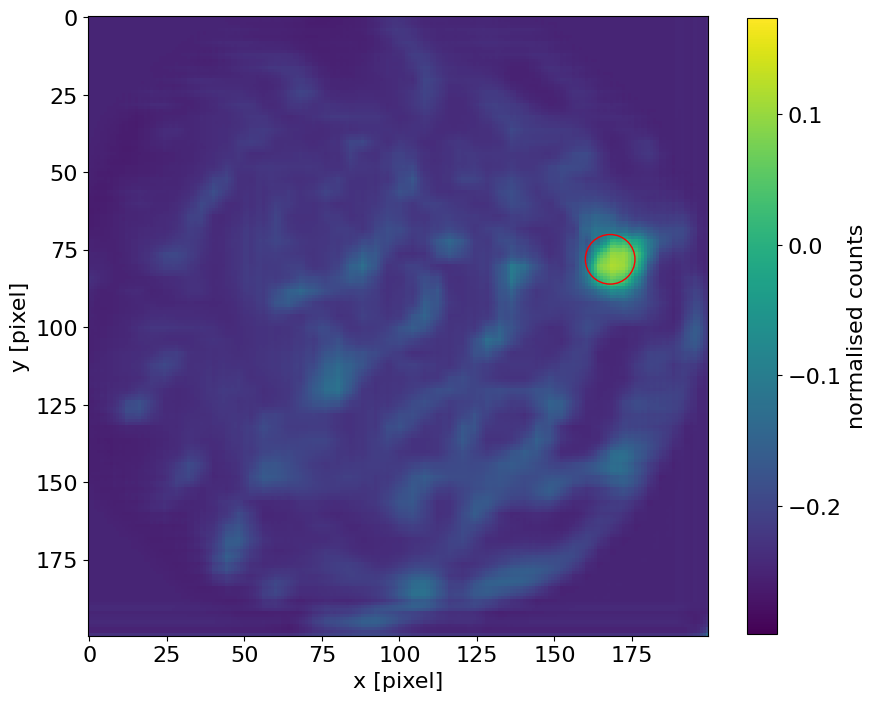

In [326]:
from matplotlib.patches import Circle

x, y = source_x, source_y
xy = source_x, source_y
radius_pix = 0.2/0.025

# STD cleaning
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

ax.imshow(test_clean[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle(xy, radius=radius_pix, edgecolor='r', facecolor='none'))
ax.set_ylabel('y [pixel]', fontsize=fs)
ax.set_xlabel('x [pixel]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('simulated counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_sim_on_region.png')
plt.show()

# CNN cleaning
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle(xy, radius=radius_pix, edgecolor='r', facecolor='none'))
ax.set_ylabel('y [pixel]', fontsize=fs)
ax.set_xlabel('x [pixel]', fontsize=fs)
#ax.set_title(f'denoised map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_cnn_on_region.png')
plt.show()


# Create on source mask

/tmp/ipykernel_1179427/766802389.py:28: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.8)


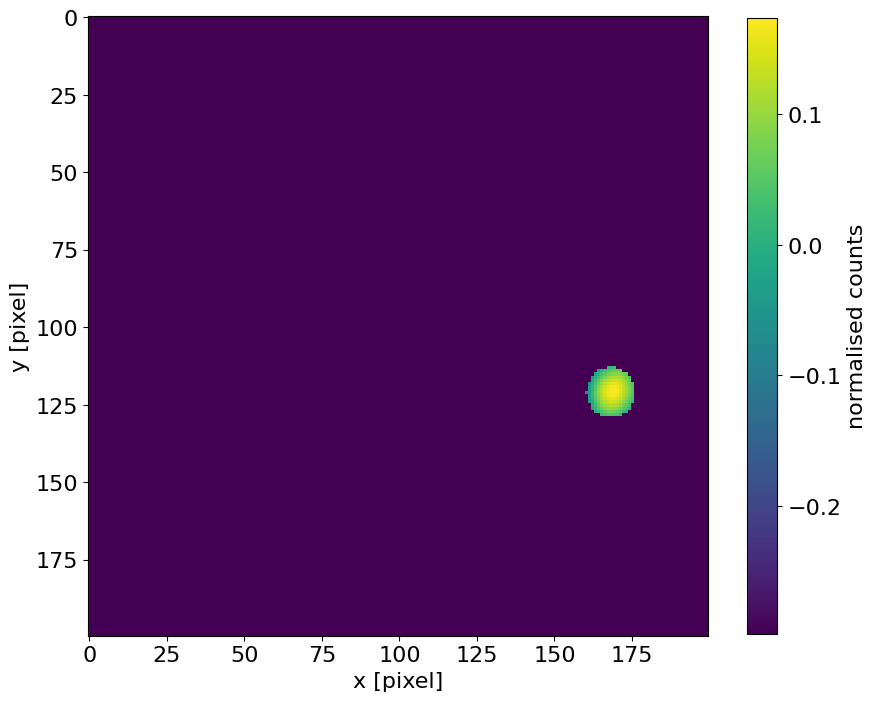

/tmp/ipykernel_1179427/766802389.py:50: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.8)


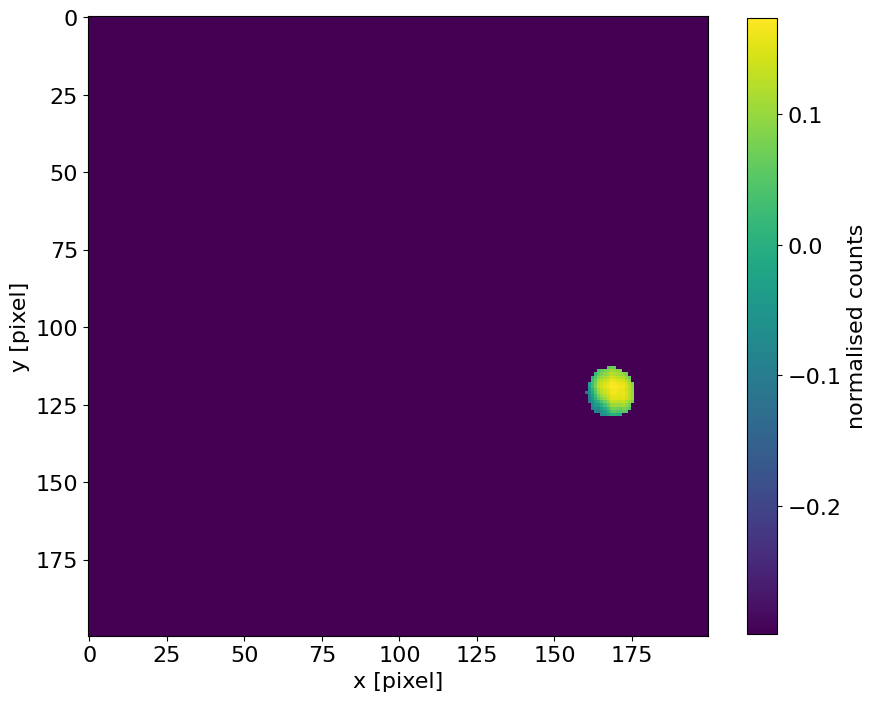

In [327]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

# STD cleaning
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

h, w = test_clean[idx].shape[:2]
mask = create_circular_mask(h, w, center=(x, y), radius=radius_pix)
masked_img1 = test_clean[idx].copy()
masked_img1[~mask] = 0

ax.imshow(np.flipud(masked_img1))
ax.set_ylabel('y [pixel]', fontsize=fs)
ax.set_xlabel('x [pixel]', fontsize=fs)
#ax.set_title(f'simulated {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_sim_on_mask.png')
plt.show()

# CNN cleaning
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

h, w = predictions[idx].shape[:2]
mask = create_circular_mask(h, w, center=(x, y), radius=radius_pix)
masked_img2 = predictions[idx].copy()
masked_img2[~mask] = 0

ax.imshow(np.flipud(masked_img2))
ax.set_ylabel('y [pixel]', fontsize=fs)
ax.set_xlabel('x [pixel]', fontsize=fs)
#ax.set_title(f'denoised {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/{seed}_cleaner_cnn_on_mask.png')
plt.show()


In [328]:
np.sum(masked_img1), np.sum(masked_img2)

(158.13792091681435, 139.64586)

# Histograms on validation set

In [329]:
sum_on_region = {'STD': [], 'CNN': [], 'AP_EXCESS': [], 'DIFF': []}

s = len(train_noisy)
for std, cnn in zip(test_clean, predictions):
    s += 1 
    row = infodata[infodata['seed']==s]
    # sky coordinates
    source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}
    # pixel coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
    x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                                   unit='deg', frame='icrs'))
    # ON counts with STD cleaning
    h, w = std.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_std = std.copy()
    masked_std[~mask] = 0

    # ON counts with CNN cleaning
    h, w = cnn.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_cnn = cnn.copy()
    masked_cnn[~mask] = 0
    
    sum_on_region['STD'].append(np.sum(masked_std))
    sum_on_region['CNN'].append(np.sum(masked_cnn))
    #sum_on_region['AP_EXCESS'].append(dl3_ph['excess'])
    sum_on_region['DIFF'].append(np.sum(masked_std - masked_cnn))

sum_on_region.keys()

dict_keys(['STD', 'CNN', 'AP_EXCESS', 'DIFF'])

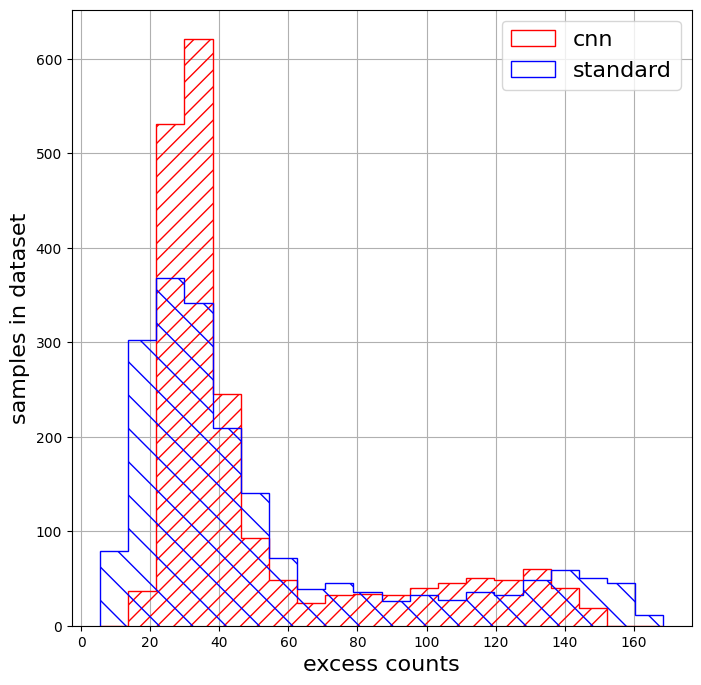

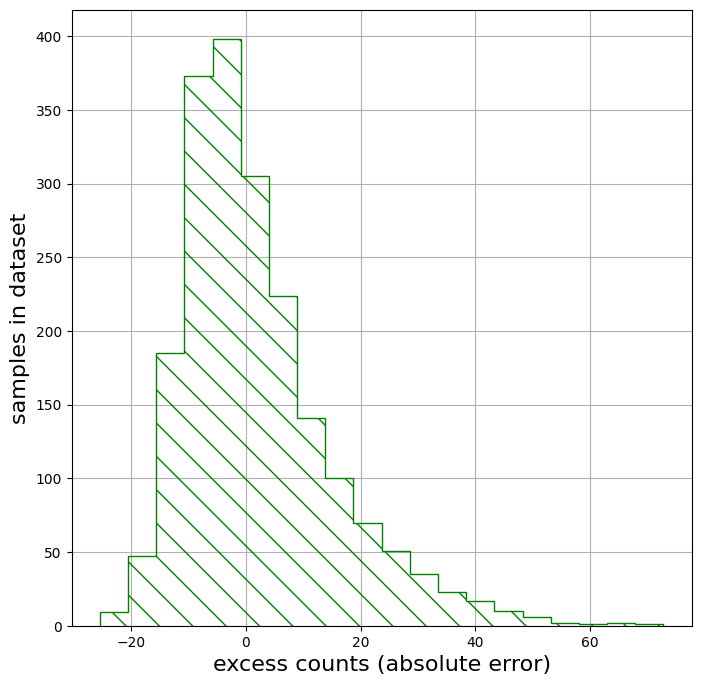

In [330]:
colors = ['blue', 'red'] 

# cumulative counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_on_region['STD'], sum_on_region['CNN']) 
#ax.set_title('residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors, label=['standard', 'cnn'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('excess counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_on_counts.png')
plt.show()

# residual hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_on_region['DIFF']
#ax.set_title('residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('excess counts (absolute error)', fontsize=fs)
ax.grid()

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_on_counts_diff.png')
plt.show()

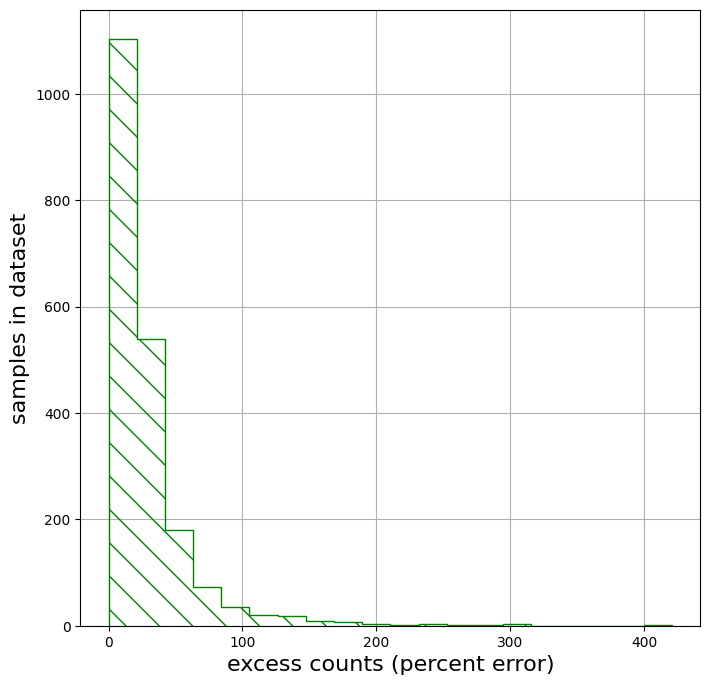

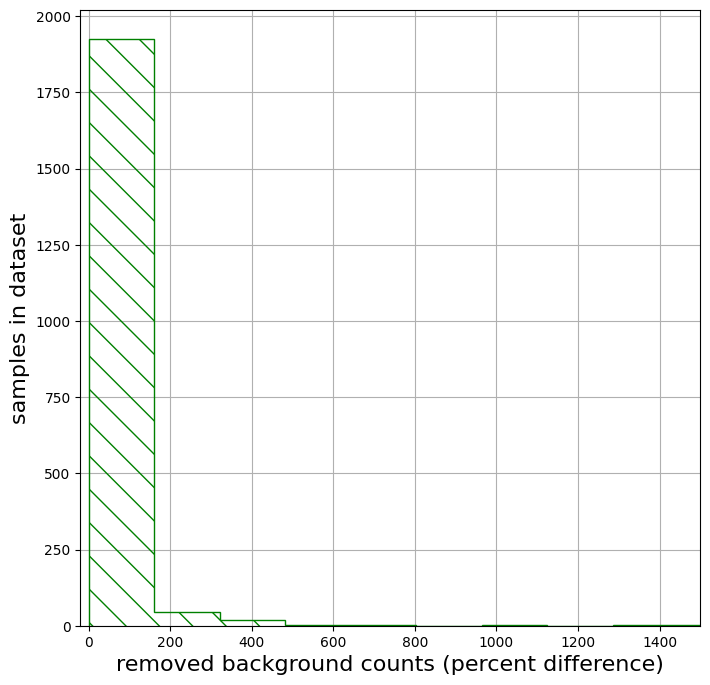

In [331]:
colors = ['blue', 'red'] 

# cumulative counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = np.abs((np.array(sum_on_region['CNN']) - np.array(sum_on_region['STD']))/np.array(sum_on_region['STD']))*100
#ax.set_title('residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('excess counts (percent error)', fontsize=fs)
#ax.legend(fontsize=fs)
ax.grid()
#ax.set_xlim([-0.2,100])

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_excess_percentage_error.png')
plt.show()

# residual hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = np.abs((np.array(sum_residual['CNN']) - np.array(sum_residual['STD']))/np.array(sum_residual['STD']))*100
#ax.set_title('residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('removed background counts (percent difference)', fontsize=fs)
ax.grid()
ax.set_xlim([-20,1500])

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_residuals_percentage_error.png')
plt.show()

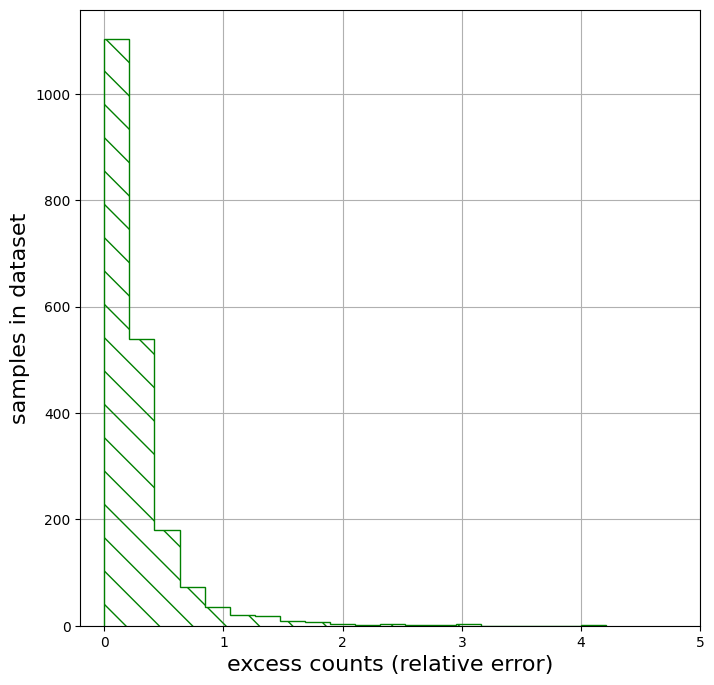

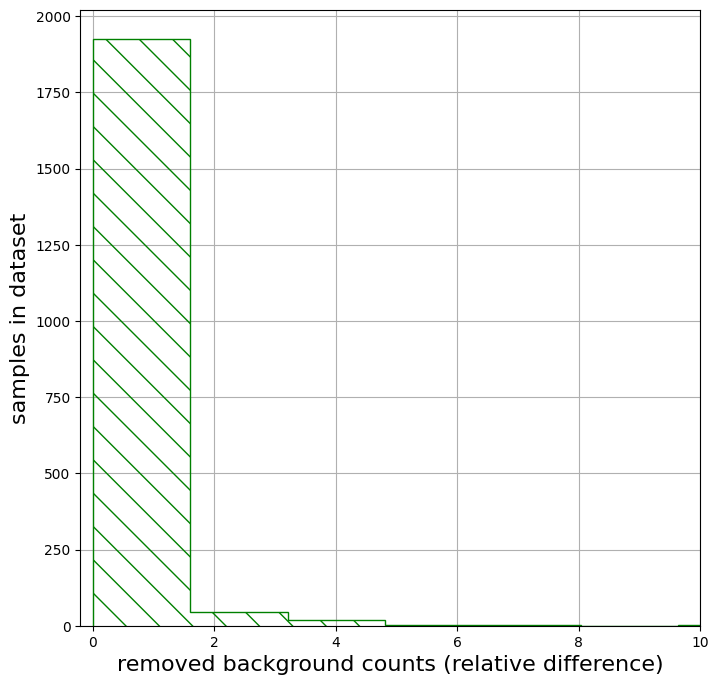

In [332]:
colors = ['blue', 'red'] 

# cumulative counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = np.abs((np.array(sum_on_region['CNN']) - np.array(sum_on_region['STD']))/np.array(sum_on_region['STD']))
#ax.set_title('residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('excess counts (relative error)', fontsize=fs)
#ax.legend(fontsize=fs)
ax.grid()
ax.set_xlim([-0.2,5])

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_excess_relative_error.png')
plt.show()

# residual hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = np.abs((np.array(sum_residual['CNN']) - np.array(sum_residual['STD']))/np.array(sum_residual['STD']))
#ax.set_title('residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('removed background counts (relative difference)', fontsize=fs)
ax.grid()
ax.set_xlim([-0.2,10])

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

fig.savefig(f'img/cleaner_ds_FINAL_residuals_relative_error.png')
plt.show()

# Errors Excess Save

In [333]:
relerr = np.abs((np.array(sum_on_region['CNN']) - np.array(sum_on_region['STD']))/np.array(sum_on_region['STD']))
percerr = np.abs((np.array(sum_on_region['CNN']) - np.array(sum_on_region['STD']))/np.array(sum_on_region['STD']))*100
abserr = (np.array(sum_on_region['CNN']) - np.array(sum_on_region['STD']))

with open(f'data/error_excess_relative_{zenith}.pickle','wb') as f: pickle.dump(relerr, f, protocol=4)
with open(f'data/error_excess_percent_{zenith}.pickle','wb') as f: pickle.dump(percerr, f, protocol=4)
with open(f'data/error_excess_absolute_{zenith}.pickle','wb') as f: pickle.dump(abserr, f, protocol=4)

np.percentile(relerr, 68)

0.27734592851152

# Errors Background Save

In [334]:
relerr = np.abs((np.array(sum_residual['CNN']) - np.array(sum_residual['STD']))/np.array(sum_residual['STD']))
percerr = np.abs((np.array(sum_residual['CNN']) - np.array(sum_residual['STD']))/np.array(sum_residual['STD']))*100
abserr = (np.array(sum_residual['CNN']) - np.array(sum_residual['STD']))

with open(f'data/error_bkg_relative_{zenith}.pickle','wb') as f: pickle.dump(relerr, f, protocol=4)
with open(f'data/error_bkg_percent_{zenith}.pickle','wb') as f: pickle.dump(percerr, f, protocol=4)
with open(f'data/error_bkg_absolute_{zenith}.pickle','wb') as f: pickle.dump(abserr, f, protocol=4)

100 - np.percentile(relerr, 100)

67.87628208486952